# MobileNet-v2

Learning Rate must be around 5e-5 or 1e-4 !!(relatively small... ResNet-50 should be around 1e-3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip drive/My\ Drive/cifar

In [0]:
import glob

train_path = './cifar/train/*.png'
test_path = './cifar/test/*.png'

train_imgs = glob.glob(train_path)
test_imgs = glob.glob(test_path)
labels = []
with open("./cifar/labels.txt", 'r') as f:
    labels = f.readlines()
label_idx_dict = {label.replace('\n',''):idx for idx, label in enumerate(labels)}
label_idx_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [0]:
import torch
import torchvision
import PIL
import time

In [0]:
transform_dict = {
    'train':torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test':torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self,img_path, label_idx_dict,transform=None):
        super(CIFAR10Dataset,self).__init__()
        self.img_path = img_path
        self.label_idx_dict = label_idx_dict
        self.transform = transform
        
    def __getitem__(self,idx):
        img_p = self.img_path[idx]
        img = PIL.Image.open(img_p)
        label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
        label_idx = self.label_idx_dict[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_idx
        
    def __len__(self):
        return len(self.img_path)

In [0]:
train_ds = CIFAR10Dataset(train_imgs, label_idx_dict, transform_dict['train'])
test_ds = CIFAR10Dataset(test_imgs, label_idx_dict, transform_dict['test'])

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [0]:
batch_size = 128
num_epoch = 100

In [0]:
net = torchvision.models.mobilenet_v2(pretrained=True)
net.classifier[1] = torch.nn.Linear(1280,10)
model_name = net.__class__.__name__
lr = 2e-4

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net.to(device)

hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
print("MODEL: {}".format(model_name))
prints_list = []
for epoch in range(num_epoch):
    cur_lr=scheduler.get_lr()[0]
    since = time.time()
    epoch_loss = 0.
    epoch_corrects = 0.
    epoch_imgs = 0.
    
    for batch in train_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(imgs)
        
        optimizer.zero_grad()
        outputs=net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * imgs.size(0)
        epoch_corrects += sum(outputs.argmax(1)==labels)
        
    l = epoch_loss / epoch_imgs
    a = epoch_corrects / epoch_imgs

    hist['loss'].append(l)
    hist['acc'].append(a)
    
    print_text = "Epoch {}: Loss: {:.4f} Acc: {:.4} Time: {:.2f}".format(epoch+1,l, a, time.time()-since)
    prints_list.append(print_text)
    print(print_text)
    
    
    net.eval()
    val_loss = 0.
    val_corrects = 0.
    val_imgs = 0.
    
    for batch in test_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        val_imgs += len(labels)
        
        with torch.no_grad():
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()*imgs.size(0)
            val_corrects += sum(outputs.argmax(1) == labels)
            
    l = val_loss / val_imgs
    a = val_corrects / val_imgs
    
    hist['val_loss'].append(l)
    hist['val_acc'].append(a)
    print_text = "Val: Loss: {:.4f} Acc: {:.4f} lr: {:.6f}".format(l, a, cur_lr)
    prints_list.append(print_text)
    print(print_text)
    
    scheduler.step()


MODEL: MobileNetV2
Epoch 1: Loss: 1.2910 Acc: 0.5413 Time: 37.00
Val: Loss: 0.9351 Acc: 0.6755 lr: 0.000200
Epoch 2: Loss: 1.1047 Acc: 0.6122 Time: 33.52
Val: Loss: 0.8532 Acc: 0.7133 lr: 0.000200
Epoch 3: Loss: 0.9719 Acc: 0.662 Time: 34.49
Val: Loss: 0.7996 Acc: 0.7141 lr: 0.000200
Epoch 4: Loss: 0.9110 Acc: 0.6825 Time: 34.21
Val: Loss: 0.6965 Acc: 0.7558 lr: 0.000200
Epoch 5: Loss: 0.8679 Acc: 0.6962 Time: 33.61
Val: Loss: 0.8195 Acc: 0.7196 lr: 0.000199
Epoch 6: Loss: 0.8480 Acc: 0.7067 Time: 33.54
Val: Loss: 0.7691 Acc: 0.7374 lr: 0.000199
Epoch 7: Loss: 0.8285 Acc: 0.7115 Time: 34.00
Val: Loss: 0.6494 Acc: 0.7692 lr: 0.000198
Epoch 8: Loss: 0.8099 Acc: 0.7167 Time: 34.52
Val: Loss: 0.7349 Acc: 0.7546 lr: 0.000198
Epoch 9: Loss: 0.7870 Acc: 0.7257 Time: 34.32
Val: Loss: 0.6235 Acc: 0.7855 lr: 0.000197
Epoch 10: Loss: 0.7793 Acc: 0.7299 Time: 33.34
Val: Loss: 0.6820 Acc: 0.7779 lr: 0.000196
Epoch 11: Loss: 0.7586 Acc: 0.7365 Time: 33.38
Val: Loss: 0.6647 Acc: 0.7823 lr: 0.000195
E

In [0]:
mb2_hist = hist

In [17]:
net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(2048,10)
model_name = net.__class__.__name__
lr=1e-3


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epoch)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net.to(device)

hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
print("MODEL: {}".format(model_name))
prints_list = []
for epoch in range(num_epoch):
    cur_lr=scheduler.get_lr()[0]
    since = time.time()
    epoch_loss = 0.
    epoch_corrects = 0.
    epoch_imgs = 0.
    
    for batch in train_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(imgs)
        
        optimizer.zero_grad()
        outputs=net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * imgs.size(0)
        epoch_corrects += sum(outputs.argmax(1)==labels)
        
    l = epoch_loss / epoch_imgs
    a = epoch_corrects / epoch_imgs

    hist['loss'].append(l)
    hist['acc'].append(a)
    
    print_text = "Epoch {}: Loss: {:.4f} Acc: {:.4} Time: {:.2f}".format(epoch+1,l, a, time.time()-since)
    prints_list.append(print_text)
    print(print_text)
    
    
    net.eval()
    val_loss = 0.
    val_corrects = 0.
    val_imgs = 0.
    
    for batch in test_dl:
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        val_imgs += len(labels)
        
        with torch.no_grad():
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()*imgs.size(0)
            val_corrects += sum(outputs.argmax(1) == labels)
            
    l = val_loss / val_imgs
    a = val_corrects / val_imgs
    
    hist['val_loss'].append(l)
    hist['val_acc'].append(a)
    print_text = "Val: Loss: {:.4f} Acc: {:.4f} lr: {:.6f}".format(l, a, cur_lr)
    prints_list.append(print_text)
    print(print_text)
    
    scheduler.step()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 271MB/s]


MODEL: ResNet
Epoch 1: Loss: 1.3246 Acc: 0.5382 Time: 42.18
Val: Loss: 0.8532 Acc: 0.7138 lr: 0.001000
Epoch 2: Loss: 1.5133 Acc: 0.4546 Time: 41.91
Val: Loss: 0.9394 Acc: 0.6803 lr: 0.001000
Epoch 3: Loss: 1.1401 Acc: 0.6018 Time: 41.89
Val: Loss: 0.8195 Acc: 0.7218 lr: 0.000999
Epoch 4: Loss: 1.0533 Acc: 0.6341 Time: 42.40
Val: Loss: 0.7266 Acc: 0.7572 lr: 0.000998
Epoch 5: Loss: 1.0145 Acc: 0.6489 Time: 41.99
Val: Loss: 0.7481 Acc: 0.7502 lr: 0.000996
Epoch 6: Loss: 0.9749 Acc: 0.6638 Time: 41.91
Val: Loss: 0.6680 Acc: 0.7746 lr: 0.000994
Epoch 7: Loss: 0.9534 Acc: 0.6709 Time: 42.08
Val: Loss: 0.7067 Acc: 0.7575 lr: 0.000991
Epoch 8: Loss: 0.9187 Acc: 0.683 Time: 42.39
Val: Loss: 0.6996 Acc: 0.7745 lr: 0.000988
Epoch 9: Loss: 0.9063 Acc: 0.6856 Time: 41.99
Val: Loss: 0.7095 Acc: 0.7660 lr: 0.000984
Epoch 10: Loss: 0.8894 Acc: 0.6917 Time: 41.87
Val: Loss: 0.6080 Acc: 0.8017 lr: 0.000980
Epoch 11: Loss: 0.8643 Acc: 0.7016 Time: 42.23
Val: Loss: 0.6050 Acc: 0.7973 lr: 0.000976
Epoch 

In [0]:
res_hist = hist

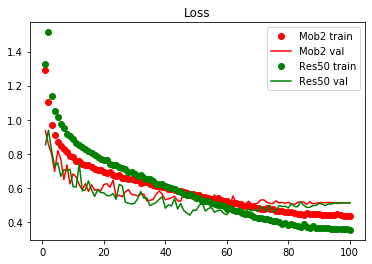

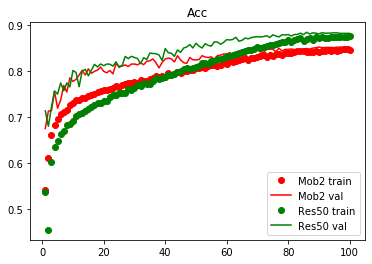

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, num_epoch+1)

plt.title('Loss')
plt.plot(epochs, mb2_hist['loss'],'ro', label='Mob2 train')
plt.plot(epochs, mb2_hist['val_loss'], 'r',label='Mob2 val')
plt.plot(epochs, res_hist['loss'],'go',label='Res50 train')
plt.plot(epochs, res_hist['val_loss'],'g',label='Res50 val')
plt.legend()
plt.show()
# plt.savefig('./mobv2_loss.png')

plt.figure()
plt.title('Acc')
plt.plot(epochs, mb2_hist['acc'], 'ro', label='Mob2 train')
plt.plot(epochs, mb2_hist['val_acc'], 'r', label='Mob2 val')
plt.plot(epochs, res_hist['acc'],'go',label='Res50 train')
plt.plot(epochs, res_hist['val_acc'],'g',label='Res50 val')
plt.legend()
plt.show()
# plt.savefig('./mobv2_acc.png')

## Discussion
Optimizer: Adam  

**Situation**:  
MobileNetv2 doesn't learn anything until 30 epochs in the first try(batch_size=1024, T_max=num_epoch/2, **lr=1e-3** )
But, in the second try(batch_size=5096), model learns a bit. 
Again, if batch_size=1024, the model doesn't learn anything.

Possible Causes:

1. T_max = num_epoch/2 causes this bad situation...? -> model stuck in the bad local optima.
2. Something wrong with code...?
3. lr=1e-3 is too big...?
4. lr=1e-3 is too small...?
5. Cosine Annealing LRScheduler should work with SGD as the original paper...? -> CosineAnnealingLR doesn't go well with Adam...?

Experiments:

1. T_max = num_epoch
2. ResNet50 instead of MobileNetv2
3. 
  * T_max = num_epoch/10 == 20
  * **lr=5e-5** 
4. Init lr=1e-1

Results:

1. Nothing happens.(Still doesn't learn)
2. ResNet50 Learns -> Code is fine...
3. 
  * Nothing happens.
  * **MobileNetv2 Learns!!**  
    Epoch 93: Loss: 0.0002 Acc: 1.0 Time: 48.925941944122314  
    Val: Loss: 2.3194 Acc: 0.7276 lr: 0.000028  
4. Nothing happens



### Comparison
Time Comparison b/w Mobilenet-v2(3.47M) and ResNet-50(25.5M)  

* Optimizer=Adam 
* lr=2e-4(Mob-2) lr=1e-3(Res-50)
* CosineAnnealingLR
* batch_size=128
* num_epoch=100
* T_max = num_epoch

#### Mobilenet-v2

* Time: **34.5** s/epoch  
* Acc: 85.27 %  

#### ResNet-50

* Time: 42 s/epoch
* Acc: **88.24** %